In [43]:
'''
!pip install pyyaml
!pip install matplotlib-venn
!pip install numpy
!pip install maya
'''

     |████████████████████████████████| 163kB 11.1MB/s eta 0:00:01
     |████████████████████████████████| 81kB 18.7MB/s eta 0:00:01
     |████████████████████████████████| 286kB 34.7MB/s eta 0:00:01
     |████████████████████████████████| 491kB 38.7MB/s eta 0:00:01
     |████████████████████████████████| 665kB 33.6MB/s eta 0:00:01
  Stored in directory: /home/ubuntu/snap/jupyter/6/.cache/pip/wheels/59/e3/55/b528efc85cc6a85b6ac7b7d7af10e82b09d1299c49aeddeaf3
Successfully built snaptime


In [44]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import re
from datetime import datetime
import maya

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup'>Setup</a>
------------------------------------
### 2. <a href='#cdist'>Column distributions</a>
### 3. <a href='#merge'>Merge launches+sqlite</a>
------------------------------------
### 4. <a href='#repo'>`column`: repo</a>
### 5. <a href='#repo'>Launches - repo analysis</a>
### 6. <a href='#ti'>Timestamp Init & Difference</a>
### 7. <a href='#ni'>Next interval</a>
### 8. <a href='#tieda'>Timestamp Weekday EDA</a>
### 9. <a href='#btd'>Batched S4-8</a>
------------------------------------

<a name='setup'></a>
## 1. Setup

<br>

In [4]:
con = sqlite3.connect('binder-launches.db')
df = pd.read_sql('SELECT * FROM binder', con)

In [5]:
df.columns

Index(['timestamp', 'version', 'provider', 'spec', 'ref', 'origin', 'repo',
       'resolved_ref', 'org'],
      dtype='object')

In [6]:
df

,timestamp,version,provider,spec,ref,origin,repo,resolved_ref,org
0,2021-01-21T00:00:00+00:00,4,GitHub,ipython/ipython-in-depth/master,master,turing.mybinder.org,ipython/ipython-in-depth,7e5ce96cc9251083979efdfc393425f1229a4a68,ipython
1,2021-01-21T00:00:00+00:00,4,GitHub,ipython/ipython-in-depth/master,master,turing.mybinder.org,ipython/ipython-in-depth,7e5ce96cc9251083979efdfc393425f1229a4a68,ipython
2,2021-01-21T00:00:00+00:00,4,GitHub,jupyterlab/jupyterlab-demo/master,master,turing.mybinder.org,jupyterlab/jupyterlab-demo,79184a07d47cf03787b39cfc345da98794d76554,jupyterlab
3,2021-01-21T00:00:00+00:00,4,GitHub,qiskit-community/qiskit-textbook/thebe-stable,thebe-stable,turing.mybinder.org,qiskit-community/qiskit-textbook,5427cf2721cc352a522832a67845d6b59e04666b,qiskit-community
4,2021-01-21T00:00:00+00:00,4,GitHub,furnstahl/5300-notebooks/master,master,gke.mybinder.org,furnstahl/5300-notebooks,aa03b995e36957a72fee85be8d2a52aea451422a,furnstahl
...,...,...,...,...,...,...,...,...,...
13946913,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython
13946914,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython
13946915,2018-11-03T23:58:00+00:00,1,GitHub,ines/spacy-io-binder/live,live,None,ines/spacy-io-binder,,ines
13946916,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython


In [7]:
dash = '-' * 60

<a name='cdist'></a>
## 2. Column distributions

<br>

<AxesSubplot:xlabel='version', ylabel='count'>

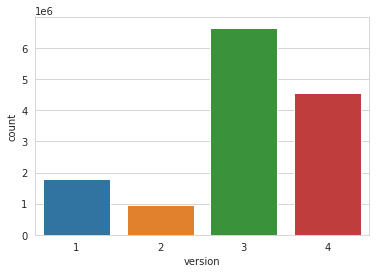

In [8]:
sns.countplot(x="version", data=df)

[Text(0, 0, 'GitHub'),
 Text(1, 0, 'Git'),
 Text(2, 0, 'Gist'),
 Text(3, 0, 'GitLab'),
 Text(4, 0, 'Zenodo'),
 Text(5, 0, 'Dataverse'),
 Text(6, 0, 'Hydroshare'),
 Text(7, 0, 'Figshare')]

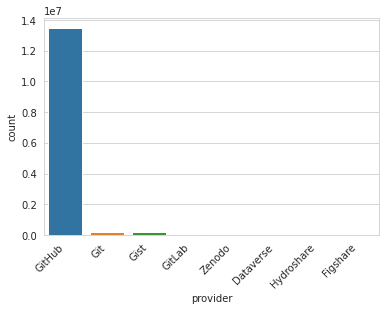

In [9]:
chart = sns.countplot(x="provider", data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

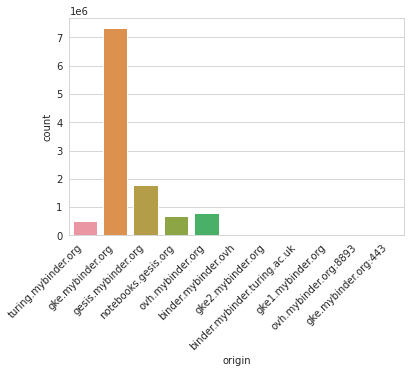

In [10]:
chart = sns.countplot(x="origin", data=df)
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

In [11]:
len(df["spec"].unique())

137685

In [12]:
len(df["repo"].unique())

112753

Since the "repo" and "ref" columns are the ones to merge with the specs dataset, it would be useful to see how many unique branches there are.

In [13]:
unique_b = len(pd.unique(df[['repo', 'ref']].values.ravel('K')))
unique_b

171770

This means that on average, each branch has about **81** entries:

In [14]:
len(df) / unique_b

81.19530767887291

<a name='merge'></a>
## 3. Merge launches+sqlite

<br>

In [58]:
'''
con = sqlite3.connect('binder-specs.sqlite')
temdf = pd.read_sql('SELECT * FROM specs', con)
merged_df = pd.merge(df, temdf,  how='inner', left_on=['repo','ref', "resolved_ref"], right_on = ['remote','git_ref', "resolved_commit"])
merged_df["repo"]
'''

'\ncon = sqlite3.connect(\'binder-specs.sqlite\')\ntemdf = pd.read_sql(\'SELECT * FROM specs\', con)\nmerged_df = pd.merge(df, temdf,  how=\'inner\', left_on=[\'repo\',\'ref\', "resolved_ref"], right_on = [\'remote\',\'git_ref\', "resolved_commit"])\nmerged_df["repo"]\n'

<a name='repo'></a>
## 4. `column`: repo

<br>

In [15]:
rp_df = df["repo"].value_counts().to_frame().reset_index()
rp_df

,index,repo
0,ipython/ipython-in-depth,4972671
1,jupyterlab/jupyterlab-demo,2573722
2,binder-examples/requirements,433068
3,ines/spacy-io-binder,335425
4,DS-100/textbook,221404
...,...,...
112747,https://jovian.ml/api/git/8cc8d3c89f654b248fa0...,1
112748,https://jovian.ml/api/git/f550eff31a884273a732...,1
112749,shwetanshu07/Machine-Learning-SP,1
112750,https://jovian.ml/api/git/5cff127e4daf44a5b37c...,1


x axis from 0 to 1000, log style

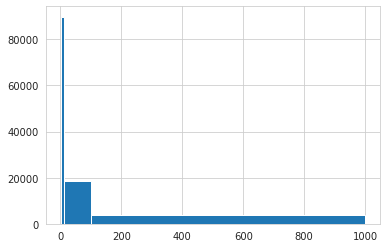

In [16]:
_ = plt.hist(rp_df["repo"], bins=(10**(np.arange(0,4))))

Same look for any set, like 100 to 10^6.

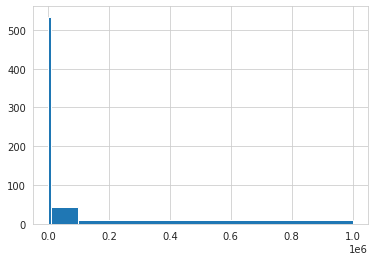

In [17]:
_ = plt.hist(rp_df["repo"], bins=(10**(np.arange(3,7))))

Frequency in each 10^x range.

In [18]:
for i in np.arange(7):
    amt = len(rp_df[(rp_df["repo"] >= (10**i))][(rp_df["repo"] < (10**(i + 1)))])
    print(str(10**i) + "-" + str(10**(i + 1)) + ": " + str(amt))
    

1-10: 89810
10-100: 18374
100-1000: 3979
1000-10000: 534
10000-100000: 44
100000-1000000: 9
1000000-10000000: 2


<a name='lra'></a>
## 5. Launches - repo analysis

<br>

A 1000+ commit repo might be interesting to look at.

In [19]:
tail_repo = rp_df[rp_df["repo"] >= 1000].iloc[-1]["index"]
tail_repo

'EstephaniaCalvo/Guia_de_Implementacion_de_Algoritmos_de_Ing_Industrial'

In [20]:
ra_df = df[df["repo"] == tail_repo]
ra_df

,timestamp,version,provider,spec,ref,origin,repo,resolved_ref,org
367701,2021-01-03T02:54:00+00:00,4,GitHub,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,master,gesis.mybinder.org,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,3eefd0f98657f02ef85184d3bd9b0308a0681027,EstephaniaCalvo
496747,2020-12-26T23:24:00+00:00,4,GitHub,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,master,gke.mybinder.org,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,3eefd0f98657f02ef85184d3bd9b0308a0681027,EstephaniaCalvo
496915,2020-12-26T23:54:00+00:00,4,GitHub,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,master,gesis.mybinder.org,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,3eefd0f98657f02ef85184d3bd9b0308a0681027,EstephaniaCalvo
496941,2020-12-26T23:59:00+00:00,4,GitHub,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,master,turing.mybinder.org,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,3eefd0f98657f02ef85184d3bd9b0308a0681027,EstephaniaCalvo
509564,2020-12-24T02:57:00+00:00,4,GitHub,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,master,gesis.mybinder.org,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,3eefd0f98657f02ef85184d3bd9b0308a0681027,EstephaniaCalvo
...,...,...,...,...,...,...,...,...,...
5447444,2020-05-09T17:24:00+00:00,3,GitHub,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,master,gesis.mybinder.org,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,,EstephaniaCalvo
5449171,2020-05-09T19:19:00+00:00,3,GitHub,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,master,gke.mybinder.org,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,,EstephaniaCalvo
5450561,2020-05-09T21:06:00+00:00,3,GitHub,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,master,gesis.mybinder.org,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,,EstephaniaCalvo
5450593,2020-05-09T21:09:00+00:00,3,GitHub,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,master,gesis.mybinder.org,EstephaniaCalvo/Guia_de_Implementacion_de_Algo...,,EstephaniaCalvo


In [21]:
ra_df.to_pickle("./1000repo_launches.pkl")

In [57]:
ra_df = pd.read_pickle("./1000repo_launches.pkl")

<a name='ti'></a>
## 6. Timestamp init & difference

<br>

In [59]:
date_str = ra_df["timestamp"].iloc[0]
date_str

'2021-01-03T02:54:00+00:00'

In [60]:
def str2date(s):
    return maya.parse(s).datetime()

In [109]:
for i in np.arange(4, 7):
    a = datetime.now()
    cut_df = df[:10**i]
    cut_df["timestamp"].apply(lambda x: str2date(x))
    b = datetime.now()
    print("10^" + str(i) + ": " + str((b-a).seconds))

10^4: 0
10^5: 6
10^6: 61


In [61]:
dt = str2date(date_str)
print(dt)
print(dt.date())
print(dt.time())
print(dt.tzinfo)

2021-01-03 02:54:00+00:00
2021-01-03
02:54:00
UTC


Subtracting two dates

In [62]:
(str2date(ra_df["timestamp"].iloc[0]) - str2date(ra_df["timestamp"].iloc[1])).total_seconds()

617400.0

All differences in one user

In [69]:
times = ra_df["timestamp"].apply(lambda x: str2date(x)).sort_values(ascending=False)
times

367701    2021-01-03 02:54:00+00:00
496941    2020-12-26 23:59:00+00:00
496915    2020-12-26 23:54:00+00:00
496747    2020-12-26 23:24:00+00:00
509627    2020-12-24 03:05:00+00:00
                     ...           
5445757   2020-05-09 15:36:00+00:00
5445740   2020-05-09 15:35:00+00:00
5445222   2020-05-09 15:05:00+00:00
5445162   2020-05-09 15:02:00+00:00
5445114   2020-05-09 15:00:00+00:00
Name: timestamp, Length: 1000, dtype: datetime64[ns, UTC]

In [76]:
time_diff = []
prev = 0
for i in times:
    if prev != 0:
        if (i - prev).seconds != 0:
            time_diff.append((i - prev).seconds)
    prev = i
time_diff[0:10]

[75900, 86100, 84600, 13260, 86280, 86040, 2520, 86220, 86280, 86220]

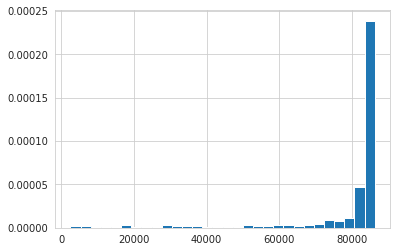

In [78]:
_ = plt.hist(time_diff, density=True, bins=30)

In [82]:
xax = np.arange(0, len(time_diff)).tolist()

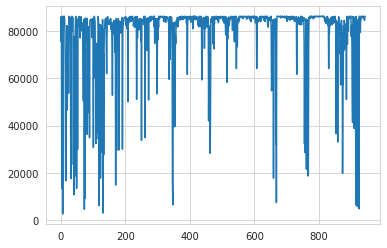

In [83]:
plt.plot(xax, time_diff)

<AxesSubplot:>

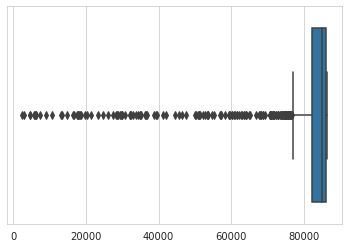

In [86]:
sns.boxplot(time_diff)

<a name='ni'></a>
## 7. Next interval

<br>

In [91]:
for i in np.arange(4):
    amt = len(list(filter(lambda x: x > 20000 * i and x < 20000 * (i+1), time_diff)))
    print(str(20000 * i) + "-" + str(20000 * (i+1)) + ": " + str(amt))

0-20000: 23
20000-40000: 29
40000-60000: 26
60000-80000: 101


<AxesSubplot:>

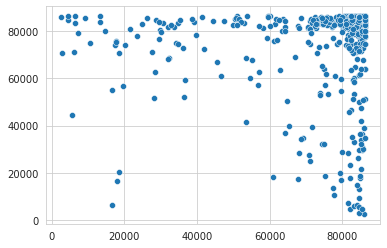

In [98]:
before_t = time_diff[:-1]
after_t = time_diff[1:]
sns.scatterplot(before_t, after_t)

<a name='tieda'></a>
## 8. Timestamp Weekday/Day/Month EDA

<br>

0 is for Monday and 6 is for Sunday.

In [158]:
(str2date(ra_df["timestamp"].iloc[0])).weekday()

6

In [161]:
times.iloc[0].weekday()

6

In [189]:
weekday = times.apply(lambda x: x.weekday()).tolist()

<AxesSubplot:ylabel='count'>

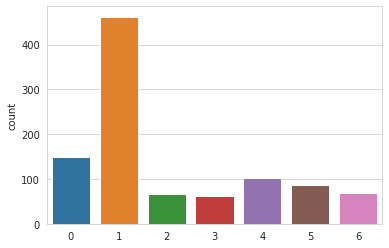

In [190]:
sns.countplot(weekday)

In [175]:
month = times.apply(lambda x: x.month).tolist()

<AxesSubplot:ylabel='count'>

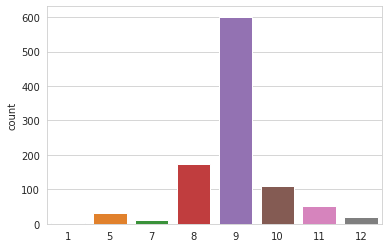

In [176]:
sns.countplot(month)

In [179]:
days = times.apply(lambda x: x.day).tolist()

<AxesSubplot:ylabel='count'>

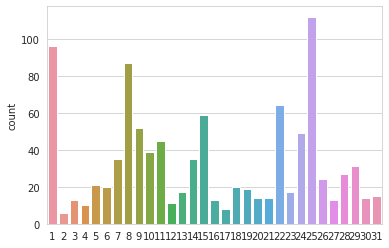

In [181]:
sns.countplot(days)

<a name='btd'></a>
## 9. Batched S5-8

<br>

EstephaniaCalvo/Guia_de_Implementacion_de_Algoritmos_de_Ing_Industrial
0-20000: 23
20000-40000: 29
40000-60000: 26
60000-80000: 101
80000-100000: 765


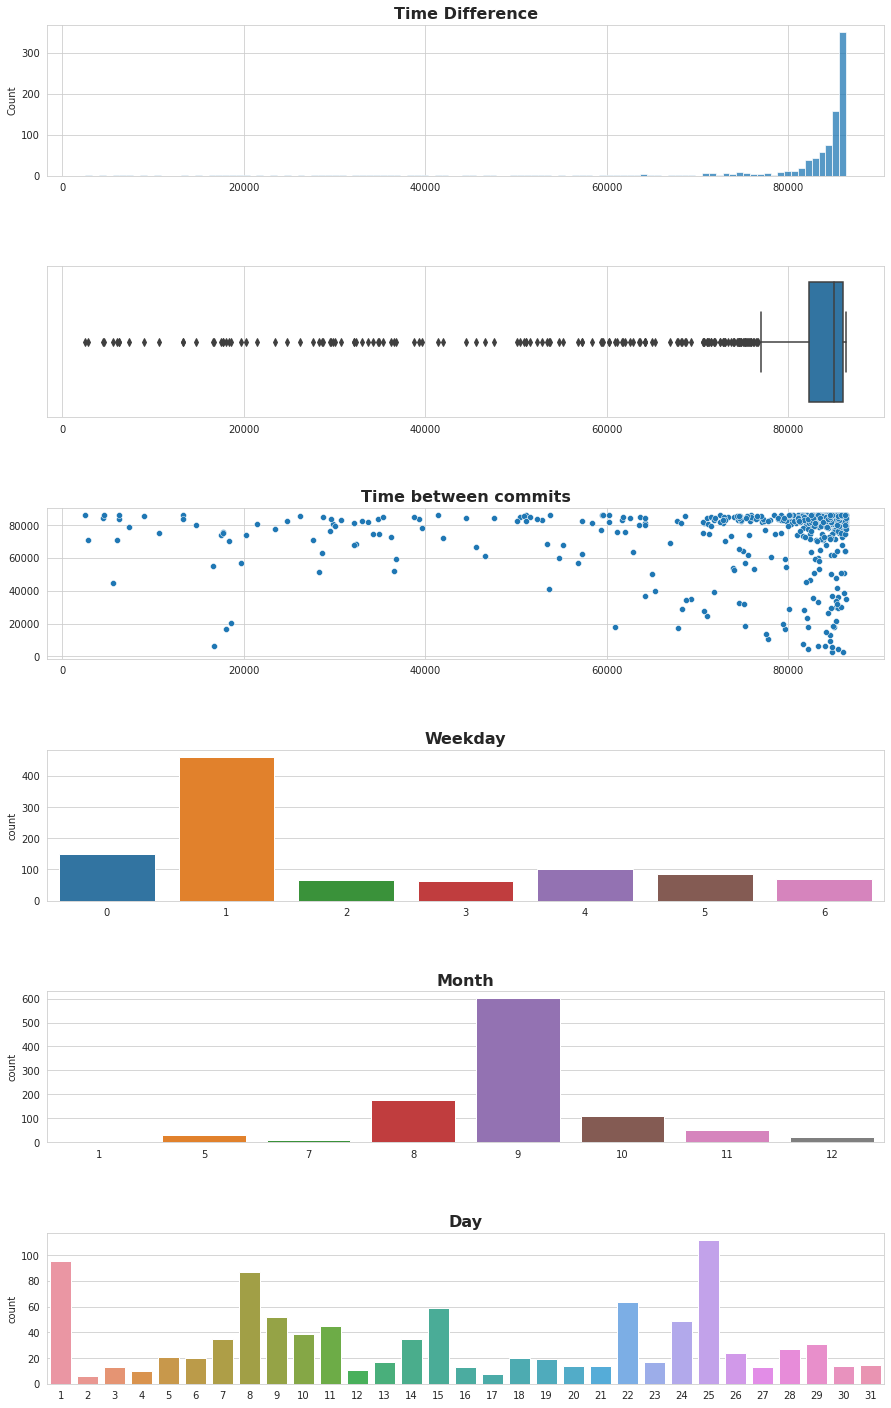

In [221]:
def str2date(s):
    return maya.parse(s).datetime()

def batch(min_count, max_count, index):
    
    fig, axs = plt.subplots(6, 1, figsize=(15,25))
    plt.subplots_adjust(hspace=0.6)
    
    #5
    tail_repo = rp_df[rp_df["repo"] >= min_count][rp_df["repo"] <= max_count].iloc[index]["index"]
    print(tail_repo)
    ra_df = df[df["repo"] == tail_repo]
    
    times = ra_df["timestamp"].apply(lambda x: str2date(x)).sort_values(ascending=False)
    time_diff = []
    prev = 0
    for i in times:
        if prev != 0:
            if (i - prev).seconds != 0:
                time_diff.append((i - prev).seconds)
        prev = i
    time_diff[0:10]
    sns.histplot(time_diff, ax=axs[0]).set_title("Time Difference", fontdict= { 'fontsize': 16, 'fontweight':'bold'})
    
    xax = np.arange(0, len(time_diff)).tolist()
    sns.boxplot(time_diff, ax=axs[1])
    
    max_amt = max(time_diff) // 20000
    for i in np.arange(max_amt + 1):
        amt = len(list(filter(lambda x: x > 20000 * i and x < 20000 * (i+1), time_diff)))
        print(str(20000 * i) + "-" + str(20000 * (i+1)) + ": " + str(amt))
        
    before_t = time_diff[:-1]
    after_t = time_diff[1:]
    sns.scatterplot(before_t, after_t, ax=axs[2]).set_title("Time between commits", fontdict= { 'fontsize': 16, 'fontweight':'bold'})
    
    #8
    weekday = times.apply(lambda x: x.weekday()).tolist()
    sns.countplot(weekday, ax=axs[3]).set_title("Weekday", fontdict= { 'fontsize': 16, 'fontweight':'bold'})
    
    month = times.apply(lambda x: x.month).tolist()
    sns.countplot(month, ax=axs[4]).set_title("Month", fontdict= { 'fontsize': 16, 'fontweight':'bold'})
    
    days = times.apply(lambda x: x.day).tolist()
    sns.countplot(days, ax=axs[5]).set_title("Day", fontdict= { 'fontsize': 16, 'fontweight':'bold'})
    
batch(1000, 1001, 2)